In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Example 1: Modified Toy Example from Textbook Chp 1

For this section, we try to recreate the simple toy example with two signals introduced in Chapter 1 of the textbook. 

### Preliminaries

In [2]:
def f1(x, t):
    return np.sin(x) * np.exp(2.3j * t)

def f2(x, t):
    return 2 * (1 / np.cosh(x)) * np.tanh(x) * np.exp(2.8j * t)

def f3(x, t):
    return np.tanh(x) * np.exp((-0.01 + 0.5j) * t)

# Mixed Signal
def f(x, t):
    return f1(x, t) + f2(x, t) + f3(x, t)

# x will be in R_400, there will be 200 time points
x_space = np.linspace(start = -10, stop = 10, num = 400)
t_vals = np.linspace(start = 0, stop = 4 * np.pi, num = 201) # 201 to basically have del_t to be 4 pi/200 and have 0 as initial condition
del_t = t_vals[1] - t_vals[0]

# Constructing Full Data Matrix
X = []
for t in t_vals:
    X.append(f(x_space, t))
X = np.asarray(X).T

# Creating the Matrices for DMD
X_1, X_2 = X[:, :-1], X[:, 1:]
print("X1 Shape:", X_1.shape)
print("X2 Shape:", X_2.shape)


X1 Shape: (400, 200)
X2 Shape: (400, 200)


### DMD Algorithm

In [3]:
def DMD(X_1, X_2, r, del_t):
    U_full, S_full, V_H_full = np.linalg.svd(X_1) # Returns U, S, V*

    # Step 1: Generate Truncated SVD Variables
    U = U_full[:, :r]
    S = np.diag(S_full[:r])
    V_H = V_H_full[:r, :]

    # Step 2: Construct A_tilde
    A_tilde = U.T.conj() @ X_2 @ V_H.T.conj() @ np.linalg.inv(S)

    # Step 3: Compute Eigendecomposition of A_tilde
    D, W = np.linalg.eig(A_tilde)

    # Step 4: Compute Exact DMD Modes:
    phi = X_2 @ V_H.T.conj() @ np.linalg.inv(S) @ W

    # Obtain Initial Conditions
    x_1 = X_1[:, 0]
    b = np.linalg.pinv(phi) @ x_1

    # Obtain continuos time eigenvalues from eigenvals of D
    D_w = np.log(D)/del_t

    return phi, b, D_w, S_full


In [4]:
# Truncated Rank 3
r = 3
singular_values_to_plot = 15

phi, b, D_w, S_full = DMD(X_1, X_2, r, del_t)

print('Phi Shape:', phi.shape)
print('b:', b)
print('Continuos Real-Time EigenValues D_w:', D_w)

Phi Shape: (400, 3)
b: [18.96445301+0.94990609j 13.53546568+2.73644428j -7.28122046+0.42875174j]
Continuos Real-Time EigenValues D_w: [-1.00000000e-02+0.5j  1.49088501e-15+2.3j  2.54002631e-15+2.8j]


### Ploting (Scaled) Singular Values

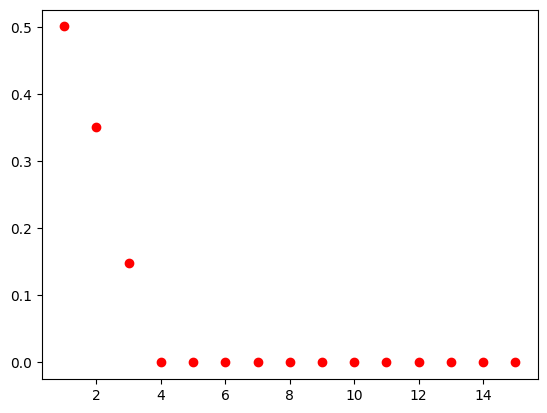

In [5]:
# Plotting First Few Singular Values

fig = plt.figure()

scaled_S_full = S_full / np.sum(S_full)

plt.scatter(np.arange(1, len(scaled_S_full[:singular_values_to_plot]) + 1), scaled_S_full[:singular_values_to_plot], color = 'r')

plt.show()

### Plotting the DMD modes (Scaled with b) w.r.t to the Initial Conditions

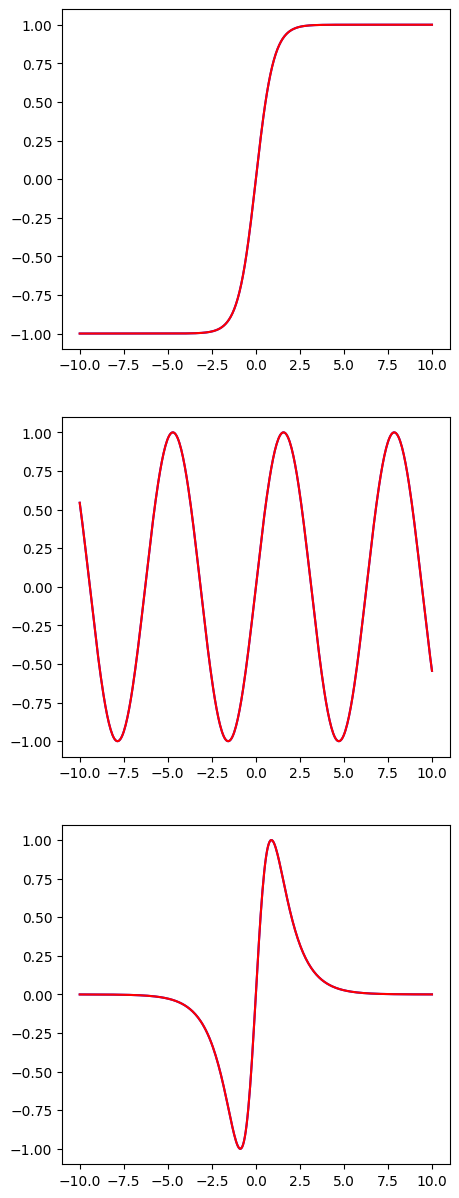

In [6]:
# Observing if the modes were decomposed correctly
initial_f1 = f1(x_space, 0)
initial_f2 = f2(x_space, 0)
initial_f3 = f3(x_space, 0)

dmd_mode_1 = phi[:, 0] 
dmd_mode_2 = phi[:, 1]
dmd_mode_3 = phi[:, 2] 
 
# Plotting the Initial Conditions
fig, ax = plt.subplots(3, 1, figsize = (5, 15))

# DMD Mode 1
ax[0].plot(x_space, np.real(initial_f3), 'b')
ax[0].plot(x_space, np.real(dmd_mode_1 * b[0]), 'r') 

# DMD Mode 2
ax[1].plot(x_space, np.real(initial_f1), 'b')
ax[1].plot(x_space, np.real(dmd_mode_2 * b[1]), 'r')

# DMD Mode 3
ax[2].plot(x_space, np.real(initial_f2), 'b')
ax[2].plot(x_space, np.real(dmd_mode_3 * b[2]), 'r')
plt.show()

### Reconstruction

In [7]:
# Initialize
X_dmd = np.zeros(X.shape) + 0j

# Reconstruction
for i in range(len(t_vals)):
    t = t_vals[i]
    x_t = phi @ np.diag(np.exp(D_w * t)) @ b
    X_dmd[:, i] = x_t

# Check if the Reconstruction is almost equal to the original (w.r.t some small default tolerance)
print("Reconstruction Equal:", np.allclose(X, X_dmd))

# Frobnorm Error
F_error = np.linalg.norm(X_dmd - X)
print("Reconstruction Error:", F_error)

# Something Similar to RMSE:
print("Custom RMSE:", np.sqrt(F_error / (X.shape[0] * X.shape[1]))) # sqrt(1/(n*m) Sum_ij (abs xij) ^ 2)

Reconstruction Equal: True
Reconstruction Error: 2.7551301029581943e-11
Custom RMSE: 1.8511560536655547e-08


### Plotting Individual Signals

c:\Users\ryanl\anaconda3\envs\RL\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.92, 'f3(x, t)')

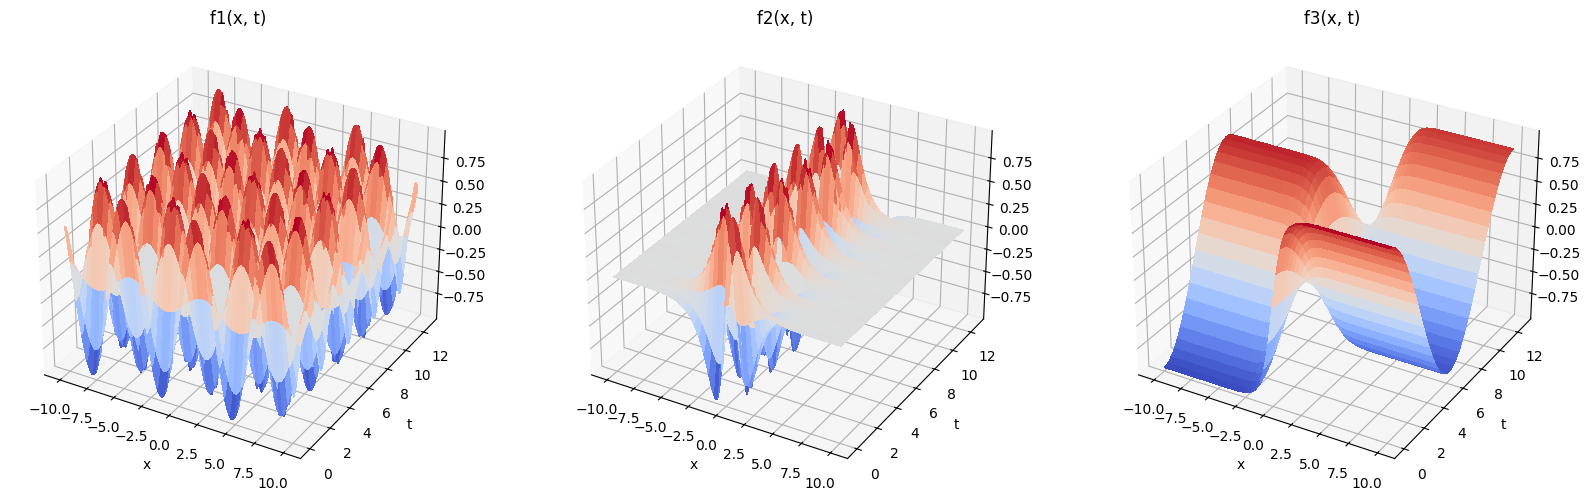

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (20, 40), subplot_kw={"projection": "3d"})
A, B = np.meshgrid(x_space, t_vals)

ax[0].plot_surface(A, B, f1(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)
ax[1].plot_surface(A, B, f2(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)
ax[2].plot_surface(A, B, f3(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)

ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('f1(x, t)')

ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('f2(x, t)')

ax[2].set_xlabel('x')
ax[2].set_ylabel('t')
ax[2].set_title('f3(x, t)')

### Plotting Original Signal Against Reconstructed Signal

Text(0.5, 0.92, 'Reconstructed')

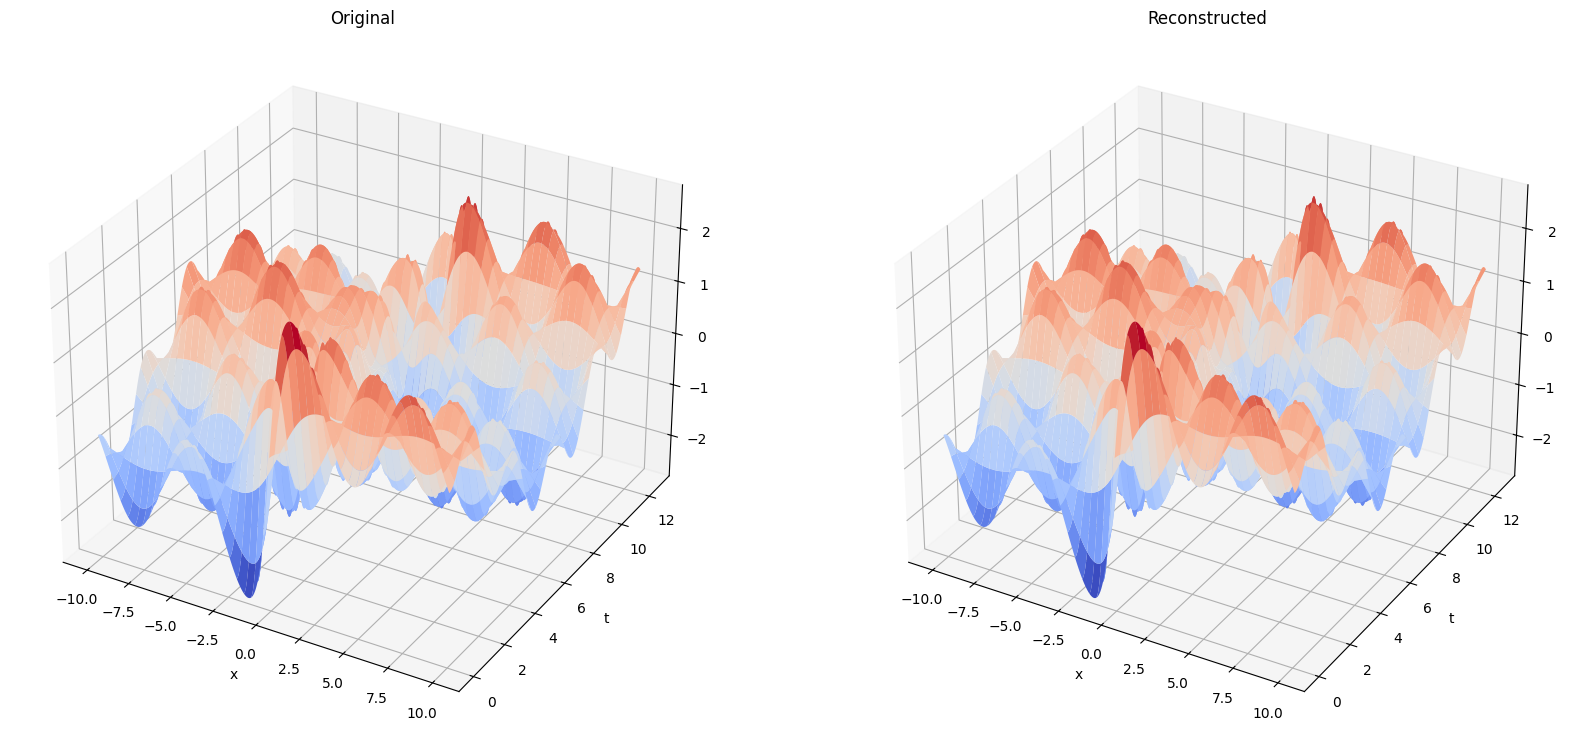

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (20, 40), subplot_kw={"projection": "3d"})
A, B = np.meshgrid(x_space, t_vals)
con = f(A, B)

ax[0].plot_surface(A, B, X.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)
ax[1].plot_surface(A, B, X_dmd.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)

ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('Original')

ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('Reconstructed')

# Example 2: Translational Invariance

In [19]:
def f1(x, t):
    return np.sin(x) * np.exp(2.3j * t) # Modification to f1

def f2(x, t):
    return 2 * (1 / np.cosh(x)) * np.tanh(x) * np.exp(2.8j * t)

def f3(x, t):
    return np.tanh(x - t) * np.exp((-0.01 + 0.5j) * t)

# Mixed Signal
def f(x, t):
    return f1(x, t) + f2(x, t) + f3(x, t)

# x will be in R_400, there will be 200 time points
x_space = np.linspace(start = -10, stop = 10, num = 400)
t_vals = np.linspace(start = 0, stop = 4 * np.pi, num = 201) # 201 to basically have del_t to be 4 pi/200 and have 0 as initial condition
del_t = t_vals[1] - t_vals[0]

# Constructing Full Data Matrix
X = []
for t in t_vals:
    X.append(f(x_space, t))
X = np.asarray(X).T

# Creating the Matrices for DMD
X_1, X_2 = X[:, :-1], X[:, 1:]
print("X1 Shape:", X_1.shape)
print("X2 Shape:", X_2.shape)


X1 Shape: (400, 200)
X2 Shape: (400, 200)


## Using Rank 3 Similar to Example 1

In [20]:
# Truncated Rank 3
r = 3
singular_values_to_plot = 20

phi, b, D_w, S_full = DMD(X_1, X_2, r, del_t)

print('Phi Shape:', phi.shape)
print('b:', b)
print('Continuos Real-Time EigenValues D_w:', D_w)

Phi Shape: (400, 3)
b: [ 20.6530885  +3.18452311j   3.17030744-12.52350542j
 -14.349851   -6.08503849j]
Continuos Real-Time EigenValues D_w: [-0.01907773+2.31863125j -0.00358036+0.42216431j -0.04334872+0.6992569j ]


### Plotting the DMD modes (Scaled with b) w.r.t to the Initial Conditions

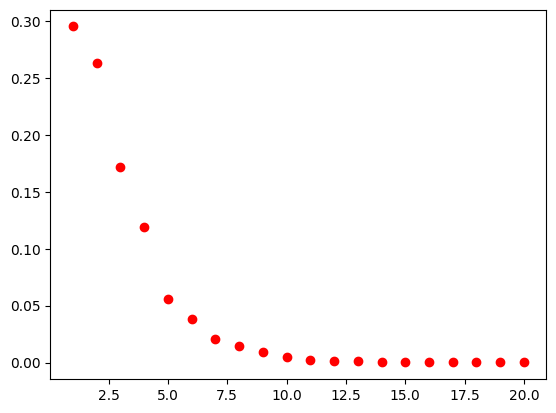

In [21]:
# Plotting First Few Singular Values

fig = plt.figure()

scaled_S_full = S_full / np.sum(S_full)

plt.scatter(np.arange(1, len(scaled_S_full[:singular_values_to_plot]) + 1), scaled_S_full[:singular_values_to_plot], color = 'r')

# Hence we choose 10 instead of 3 as in Example 1
plt.show()

In [22]:
# Initialize
X_dmd = np.zeros(X.shape) + 0j

# Reconstruction
for i in range(len(t_vals)):
    t = t_vals[i]
    x_t = phi @ np.diag(np.exp(D_w * t)) @ b
    X_dmd[:, i] = x_t

# Check if the Reconstruction is almost equal to the original (w.r.t some small default tolerance)
print("Reconstruction Equal:", np.allclose(X, X_dmd))

# Frobnorm Error
F_error = np.linalg.norm(X_dmd - X)
print("Reconstruction Error:", F_error)

# Something Similar to RMSE:
print("Custom RMSE:", np.sqrt(F_error / (X.shape[0] * X.shape[1]))) # sqrt(1/(n*m) Sum_ij (abs xij) ^ 2)

Reconstruction Equal: False
Reconstruction Error: 161.40179879655463
Custom RMSE: 0.04480496690835336


### Plotting Original Signal Against Reconstructed Signal

Text(0.5, 0.92, 'Reconstructed')

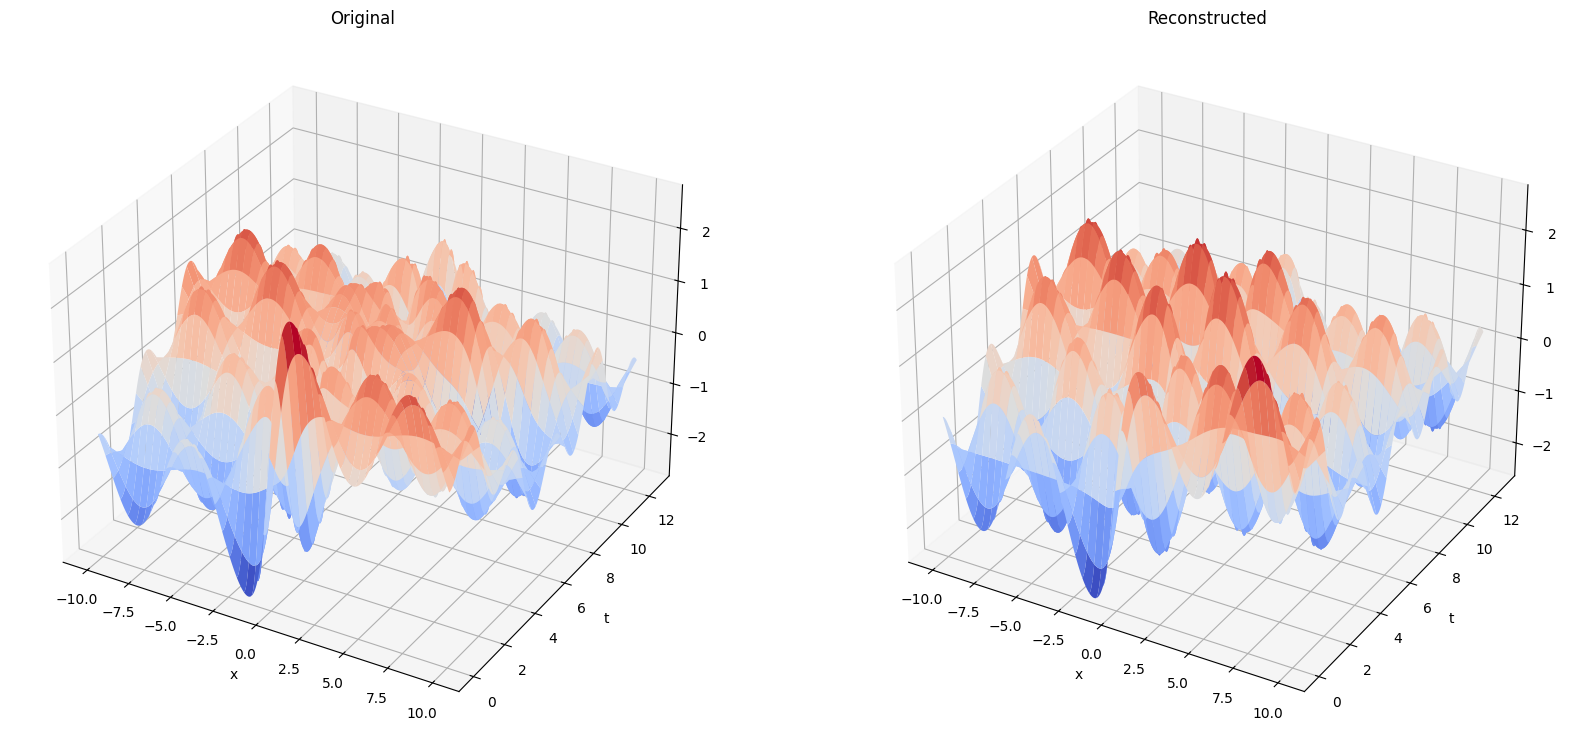

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (20, 40), subplot_kw={"projection": "3d"})
A, B = np.meshgrid(x_space, t_vals)
con = f(A, B)

ax[0].plot_surface(A, B, X.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)
ax[1].plot_surface(A, B, X_dmd.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)

ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('Original')

ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('Reconstructed')

## Using Rank 10 Instead with respect to the Singular Value Plot

In [24]:
# Truncated Rank 3
r = 10
singular_values_to_plot = 20

phi, b, D_w, S_full = DMD(X_1, X_2, r, del_t)

print('Phi Shape:', phi.shape)
print('b:', b)
print('Continuos Real-Time EigenValues D_w:', D_w)

Phi Shape: (400, 10)
b: [ -7.10967682 +2.22034693j  13.71615011 +1.3559439j
   0.56995071 -0.07846933j  -0.65334149 +1.98917388j
   7.62588508 -3.6314416j  -16.31272615-33.40109738j
  21.43290583 +0.29323807j -27.29690547+30.78829798j
  -2.20097715 +0.46144584j   7.74775802 +3.531698j  ]
Continuos Real-Time EigenValues D_w: [-6.40290981e-04+2.80834317j -6.59850718e-05+2.30009694j
 -6.23537093e-02-1.30215328j -1.15083769e-01-0.7380253j
 -1.79517254e-01-0.19013925j -2.93980431e-01+0.28768417j
 -1.44639193e-02+0.49690776j -2.54662151e-01+0.65880137j
 -1.17740377e-01+1.69860335j -1.78910071e-01+1.16478601j]


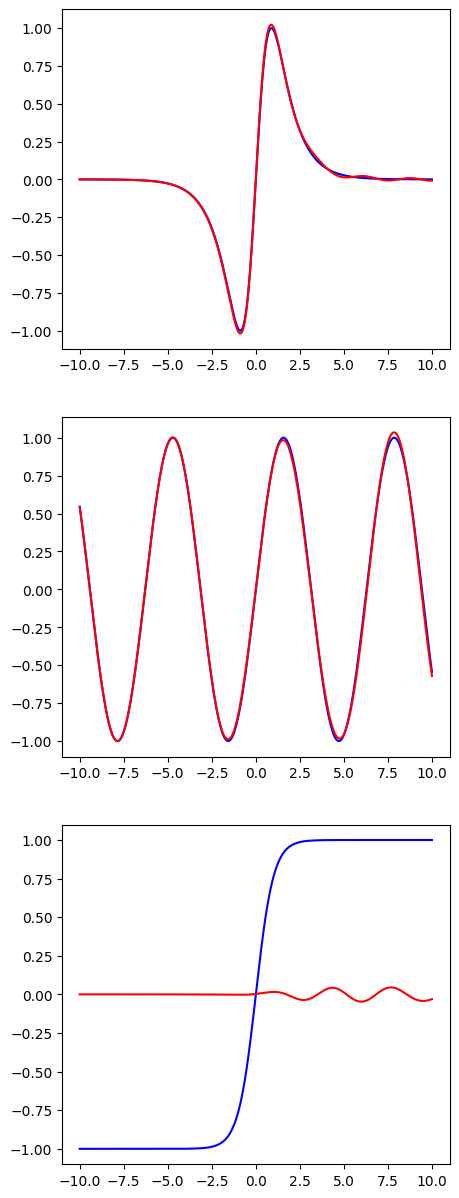

In [25]:
# Observing if the modes were decomposed correctly
initial_f1 = f1(x_space, 0)
initial_f2 = f2(x_space, 0)
initial_f3 = f3(x_space, 0)

dmd_mode_1 = phi[:, 0] 
dmd_mode_2 = phi[:, 1]
dmd_mode_3 = phi[:, 2] 

 
# Plotting the Initial Conditions
fig, ax = plt.subplots(3, 1, figsize = (5, 15))

# DMD Mode: Continuous time eigenval closest to 0+2.3j
ax[0].plot(x_space, np.real(initial_f2), 'b')
ax[0].plot(x_space, np.real(dmd_mode_1 * b[0]), 'r') 

# DMD Mode: Continuous time eigenval closest to 0+2.8j
ax[1].plot(x_space, np.real(initial_f1), 'b')
ax[1].plot(x_space, np.real(dmd_mode_2 * b[1]), 'r')

# DMD Mode:
ax[2].plot(x_space, np.real(initial_f3), 'b')
ax[2].plot(x_space, np.real(dmd_mode_3 * b[2]), 'r')
plt.show()

In [26]:
# Initialize
X_dmd = np.zeros(X.shape) + 0j

# Reconstruction
for i in range(len(t_vals)):
    t = t_vals[i]
    x_t = phi @ np.diag(np.exp(D_w * t)) @ b
    X_dmd[:, i] = x_t

# Check if the Reconstruction is almost equal to the original (w.r.t some small default tolerance)
print("Reconstruction Equal:", np.allclose(X, X_dmd))

# Frobnorm Error
F_error = np.linalg.norm(X_dmd - X)
print("Reconstruction Error:", F_error)

# Something Similar to RMSE:
print("Custom RMSE:", np.sqrt(F_error / (X.shape[0] * X.shape[1]))) # sqrt(1/(n*m) Sum_ij (abs xij) ^ 2)

Reconstruction Equal: False
Reconstruction Error: 4.930899362203659
Custom RMSE: 0.00783132134810336


### Plotting Individual Signals

Text(0.5, 0.92, 'f3(x, t)')

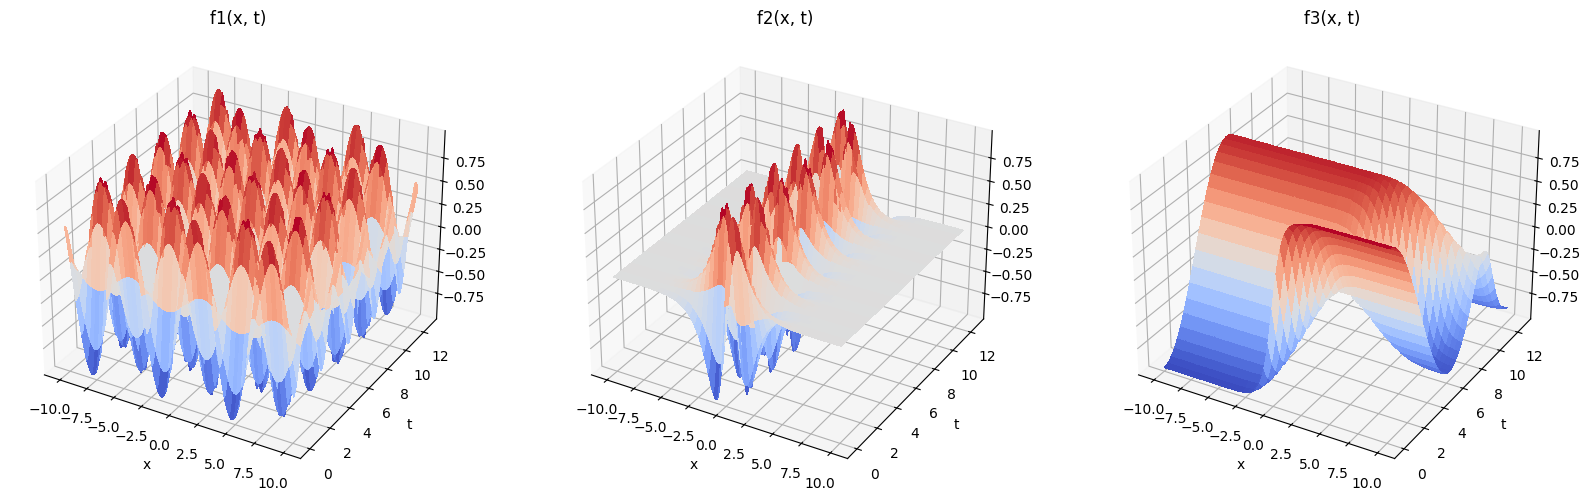

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (20, 40), subplot_kw={"projection": "3d"})
A, B = np.meshgrid(x_space, t_vals)

ax[0].plot_surface(A, B, f1(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)
ax[1].plot_surface(A, B, f2(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)
ax[2].plot_surface(A, B, f3(A, B), cmap='coolwarm',
                       linewidth=0, antialiased=False)

ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('f1(x, t)')

ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('f2(x, t)')

ax[2].set_xlabel('x')
ax[2].set_ylabel('t')
ax[2].set_title('f3(x, t)')

### Plotting Original Signal Against Reconstructed Signal

Text(0.5, 0.92, 'Reconstructed')

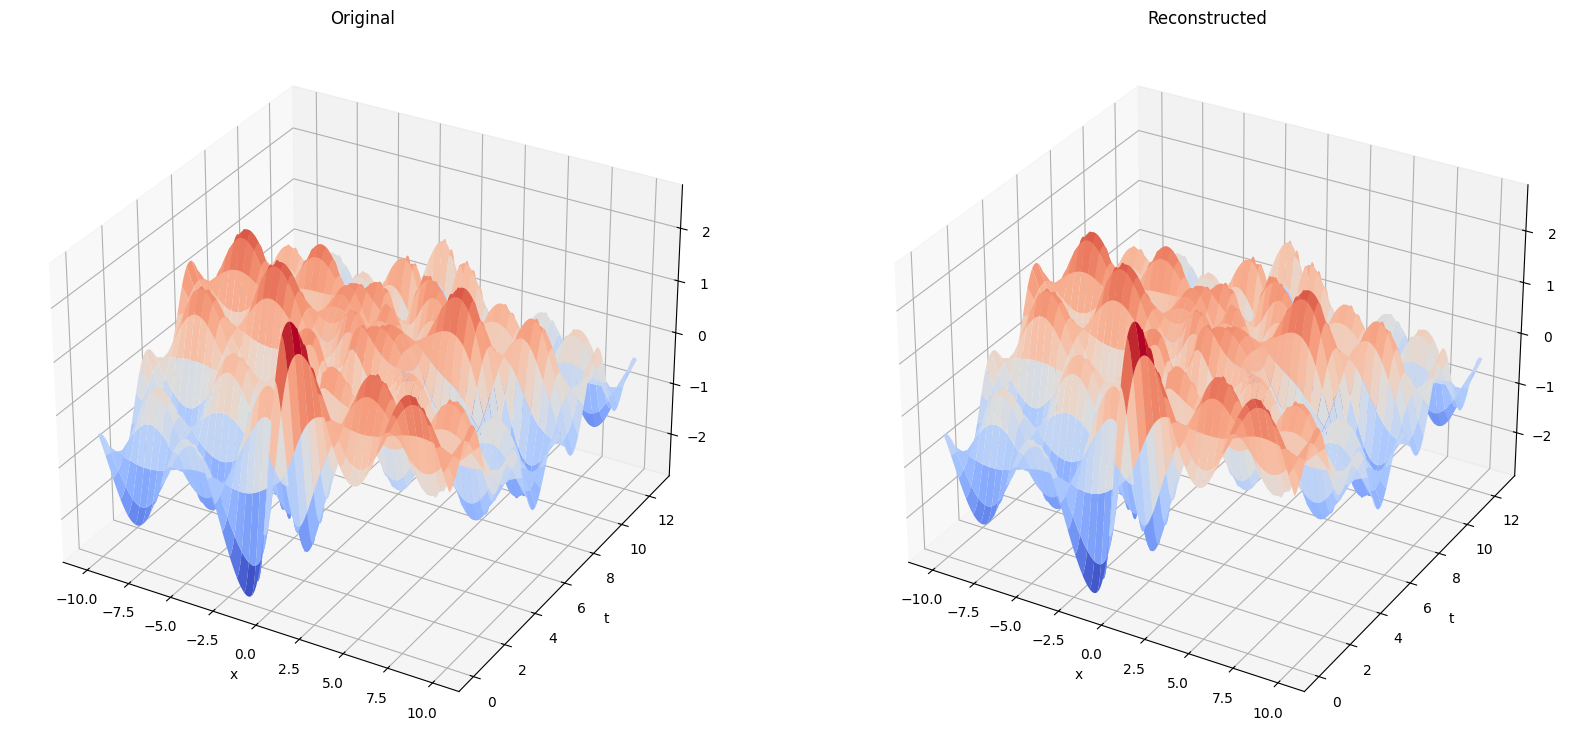

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (20, 40), subplot_kw={"projection": "3d"})
A, B = np.meshgrid(x_space, t_vals)
con = f(A, B)

ax[0].plot_surface(A, B, X.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)
ax[1].plot_surface(A, B, X_dmd.T, cmap='coolwarm',
                       linewidth=0, antialiased=True)

ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('Original')

ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('Reconstructed')

# Example 3: Chapter 3 Second Example on 2 Variable ODE with Koopman

We will use the 2-variable non linear differential equations as found in Chapter 3:

$x_1^{'}(t) = \mu x_1$

$x_2^{'}(t) = \lambda (x_2 - x_1^{2})$

where $ \mu, \lambda \ne 0 $. Suppose that the initial conditions of $x_1$ and $x_2$ follow:

$x_1(0) = a, x_2(0) = b$

where $ a \ne 0$. Then, when solving the differential equations exactly, we have:

$x_1(t) = a \exp(\mu t)$

$x_2(t) = a^{2} \lambda (\frac{1}{\lambda - 2 \mu} \exp(2 \mu t) + C \exp(\lambda t))$

where $ C = \frac{b}{a^{2} \lambda} - \frac{1}{\lambda - 2 \mu}$

For this example, following the original text, we have 3 observable functions such that restricting the Koopman operator to the subspace spanned by these 3 observable functions, by projecting the coordinates from the original state space to the new 3D space using the observable functions, we can obtain a linear dynamical system with respect to the projected coordinates.

Here, we will just show Koopman Model here will yield a better approximation to the non linear dynamics than the standard DMD Model, especially since we know that the 3 observable functions belong to a aubspace spanned by the eigenfunctions of the Koopman Operator (can be shown). 

In [34]:
# Define the confiigurables for the Original System
lmbda = -1.0
mu = -0.01
a = 5
b = 10

# Defining how X1 and X2 evolve with time
def x1_dynamics(a, mu, t):
    return a * np.exp(mu * t)

def x2_dynamics(a, b, lmbda, mu, t):
    
    C = (b / ((a ** 2) * lmbda)) - (1 / (lmbda - 2 * mu))

    return (a ** 2) * lmbda * ((1 / (lmbda - 2 * mu)) * np.exp(2 * mu * t) + C * np.exp(lmbda * t))

t_vals = np.linspace(start = 0, stop = 100, num = 201)
del_t = t_vals[1] - t_vals[0]

# Creating the datapoints at different timepoints
x1 = x1_dynamics(a, mu, t_vals)
x2 = x2_dynamics(a, b, lmbda, mu, t_vals)
X = np.asarray([x1, x2])

X_1, X_2 = X[:, :-1], X[:, 1:]

print("X1 Shape:", X_1.shape)
print("X2 Shape:", X_2.shape)

X1 Shape: (2, 200)
X2 Shape: (2, 200)


### Plot to show that as time t increases, $x_2$ converges to $x_1^{2}$

Text(0.5, 1.0, 'Trajectory of Variables')

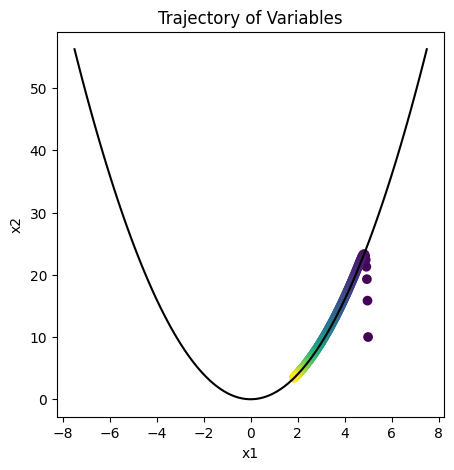

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

x1_linspace = np.linspace(-7.5, 7.5, 100)
x2_linspace = x1_linspace ** 2

# Plot the x2 = x1 ^ 2 line
ax.plot(x1_linspace, x2_linspace, 'k')

# Plotting the Trajectory w.r.t time
ax.scatter(x1, x2, c = np.arange(1, len(x1) + 1)) # As t increases, the color goes from Darker to Lighter

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Trajectory of Variables")

### Original DMD Model

In [26]:
# Rank 2
r = 2

phi, b, D_w, S_full = DMD(X_1, X_2, r, del_t)

print('Phi Shape:', phi.shape)
print('b:', b)
print('Continuos Real-Time EigenValues D_w:', D_w)

Phi Shape: (2, 2)
b: [-21.69672767 -11.40226376]
Continuos Real-Time EigenValues D_w: [-0.01       -0.07155638]


In [28]:
# Initialize
X_dmd = np.zeros(X.shape)

# Reconstruction
for i in range(len(t_vals)):
    t = t_vals[i]
    x_t = phi @ np.diag(np.exp(D_w * t)) @ b
    X_dmd[:, i] = x_t

# Check if the Reconstruction is almost equal to the original (w.r.t some small default tolerance)
print("Reconstruction Equal:", np.allclose(X, X_dmd))

# Frobnorm Error
F_error = np.linalg.norm(X_dmd - X)
print("Reconstruction Error:", F_error)

# Something Similar to RMSE:
print("Custom RMSE:", np.sqrt(F_error / (X.shape[0] * X.shape[1]))) # sqrt(1/(n*m) Sum_ij (abs xij) ^ 2)

Reconstruction Equal: False
Reconstruction Error: 64.62337681845747
Custom RMSE: 0.400942226140663


### Koopman Model

In [29]:
# Define New Coordinates with respect to the observable functions
Y = np.asarray([x1, x2, x1**2])

Y_1, Y_2 = Y[:, :-1], Y[:, 1:]

print("Y1 Shape:", Y_1.shape)
print("Y2 Shape:", Y_2.shape)

Y1 Shape: (3, 200)
Y2 Shape: (3, 200)


In [30]:
# Rank 3
r = 3

phi, b, D_w, S_full = DMD(Y_1, Y_2, r, del_t)

print('Phi Shape:', phi.shape)
print('b:', b)
print('Continuos Real-Time EigenValues D_w:', D_w)

Phi Shape: (3, 3)
b: [-25.57200338  36.07690101  -5.0250626 ]
Continuos Real-Time EigenValues D_w: [-1.   -0.02 -0.01]


In [31]:
# Initialize
Y_dmd = np.zeros(Y.shape)

# Reconstruction
for i in range(len(t_vals)):
    t = t_vals[i]
    y_t = phi @ np.diag(np.exp(D_w * t)) @ b
    Y_dmd[:, i] = y_t

# Obtain back the original X from the reconstructed Y
X_dmd_from_Y = Y_dmd[0:2, :]

# Check if the Reconstruction is almost equal to the original (w.r.t some small default tolerance)
print("Reconstruction Equal:", np.allclose(X, X_dmd_from_Y))

# Frobnorm Error
F_error = np.linalg.norm(X_dmd_from_Y - X)
print("Reconstruction Error:", F_error)

# Something Similar to RMSE:
print("Custom RMSE:", np.sqrt(F_error / (X.shape[0] * X.shape[1]))) # sqrt(1/(n*m) Sum_ij (abs xij) ^ 2)

Reconstruction Equal: True
Reconstruction Error: 1.2658654620658414e-11
Custom RMSE: 1.774519388416277e-07


Thus, from the above example, the Koopman Model produces results exactly similar to the true solution. While the original DMD is able to accuractely reconstruct the vector x_1, it is unable to accuratley reconstruct vector x_2, thus leading to significant reconstruction error as seen above.